In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import itertools
import json
import pickle

In [ ]:
df = pd.read_csv('football.csv')

In [ ]:
df, test_df = train_test_split(df)

In [ ]:
test_df.to_csv('test_df.csv', index=False)

In [ ]:
# Remove % sign from fpl_sel and convert to float
df.fpl_sel = df.fpl_sel.apply(lambda x : float(x[:-1]))

In [ ]:
df.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
111,Tiemoue Bakayoko,Chelsea,22,DM,2,16.0,1011,5.0,1.6,0,2.0,France,1,2,5,1,0
253,Vincent Kompany,Manchester+City,31,CB,3,22.0,935,6.0,6.6,57,2.0,Belgium,0,4,11,1,0
428,Jonny Evans,West+Brom,29,CB,3,7.0,375,5.0,1.6,79,2.0,Northern Ireland,0,4,19,0,0
299,Christian Atsu,Newcastle+United,25,RW,1,5.0,641,5.0,2.1,0,4.0,Ghana,0,3,13,0,0
308,Ryan Bertrand,Southampton,27,LB,3,20.0,578,5.5,11.2,123,1.0,England,0,3,14,0,0


In [ ]:
    df.describe()

,age,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,344.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,26.637681,2.176812,11.161014,777.684058,5.443478,3.274493,57.205797,1.968023,0.040580,3.153623,10.510145,0.313043,0.142029
std,4.055469,0.994483,12.532322,953.450686,1.318085,5.761080,52.175865,0.954731,0.197601,1.315005,5.630124,0.464405,0.349587
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,235.000000,4.500000,0.200000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,461.000000,5.000000,1.100000,52.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,950.000000,5.500000,3.300000,93.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,36.000000,4.000000,75.000000,7664.000000,11.500000,45.000000,225.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


One null value in region. Som drop that record

In [ ]:
df = df.dropna()
df.shape

(344, 17)

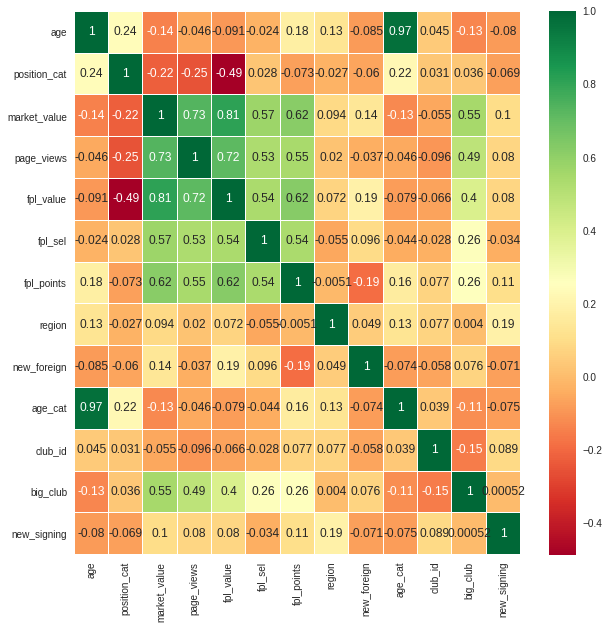

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, linewidth = 0.02,cmap = 'RdYlGn')
plt.show()

Either use age or age_cat. They are highly correlated

Also, fpl_value, page_views are important for market_value

In [ ]:
removed_df = df.drop(['name','club','age_cat','position'], axis=1)

In [ ]:
removed_df.head()

,age,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,club_id,big_club,new_signing
111,22,2,16.0,1011,5.0,1.6,0,2.0,France,1,5,1,0
253,31,3,22.0,935,6.0,6.6,57,2.0,Belgium,0,11,1,0
428,29,3,7.0,375,5.0,1.6,79,2.0,Northern Ireland,0,19,0,0
299,25,1,5.0,641,5.0,2.1,0,4.0,Ghana,0,13,0,0
308,27,3,20.0,578,5.5,11.2,123,1.0,England,0,14,0,0


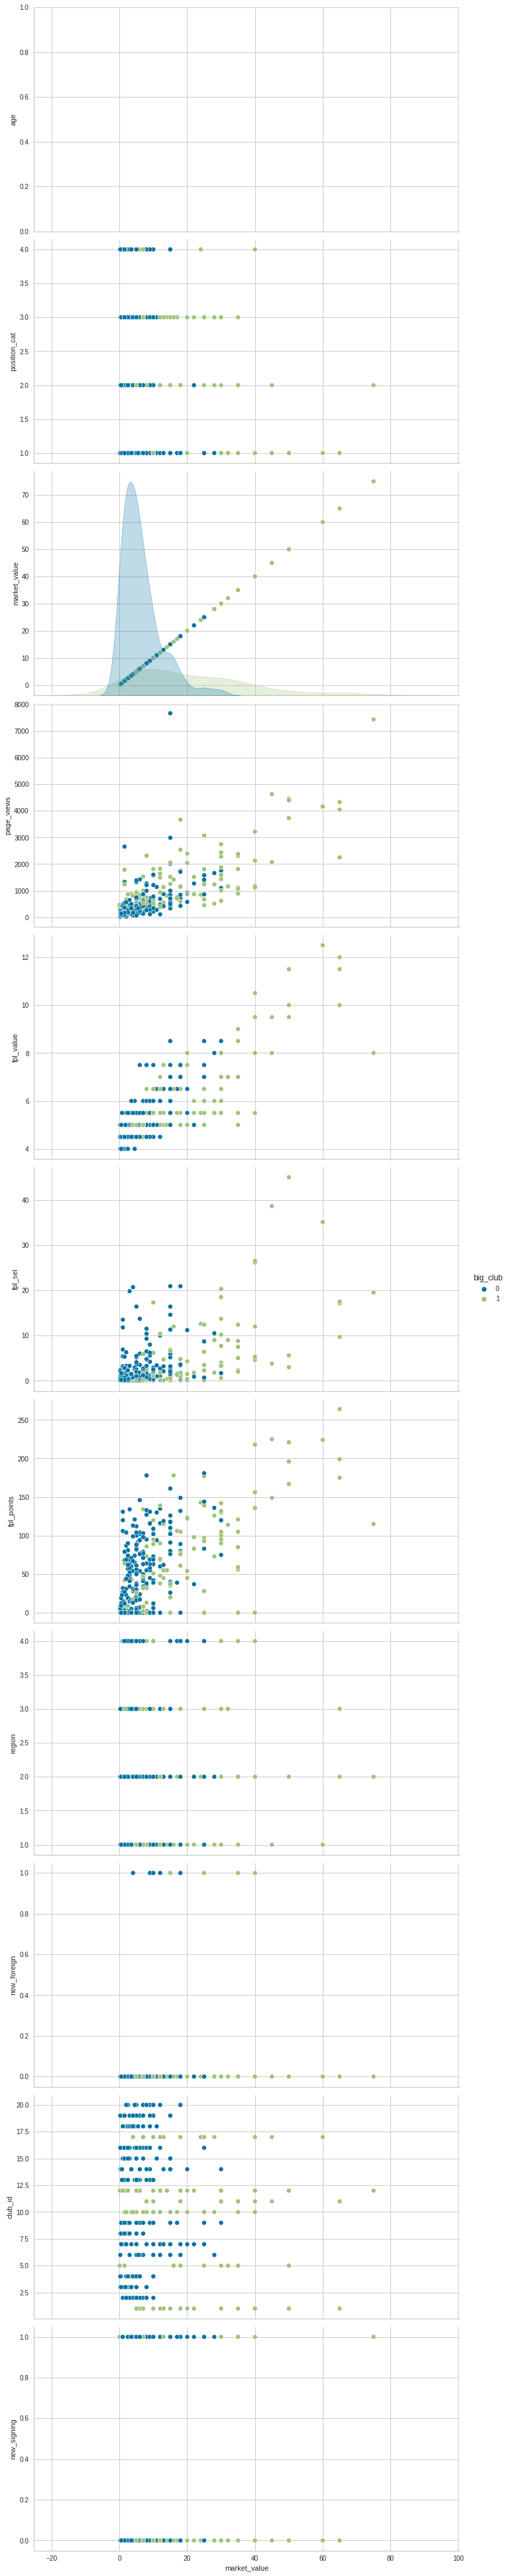

In [ ]:
sns.pairplot(removed_df, x_vars='market_value', hue = 'big_club', height = 5, aspect = 2)

The continuous variables are nicely correlated with the market value. Mostly linear

Those who belong to big club have higher market value

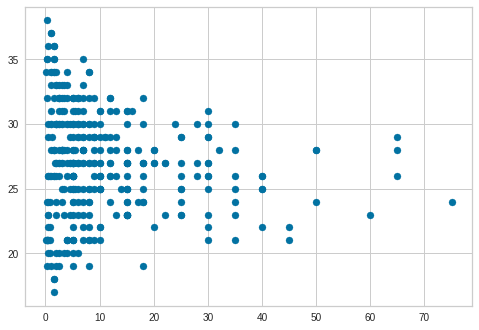

In [ ]:
plt.scatter(removed_df.market_value, removed_df.age)

Interestingly, it looks like a normal distribution.

Players aged around 25 have higher market value

**Binning might help**

* I'll bring back the age_cat attribute and move further with that one

In [ ]:
removed_df = pd.concat([removed_df.drop('age', axis=1), df.age_cat], axis=1)

In [ ]:
removed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 111 to 217
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   position_cat  344 non-null    int64  
 1   market_value  344 non-null    float64
 2   page_views    344 non-null    int64  
 3   fpl_value     344 non-null    float64
 4   fpl_sel       344 non-null    float64
 5   fpl_points    344 non-null    int64  
 6   region        344 non-null    float64
 7   nationality   344 non-null    object 
 8   new_foreign   344 non-null    int64  
 9   club_id       344 non-null    int64  
 10  big_club      344 non-null    int64  
 11  new_signing   344 non-null    int64  
 12  age_cat       344 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 37.6+ KB


In [ ]:
all_columns = removed_df.columns
category_cols = ['position_cat', 'region', 'nationality', 'new_foreign', 'club_id', 'big_club', 'new_signing', 'age_cat']

In [ ]:
final_df = removed_df.copy()
final_df.reset_index(drop=True, inplace=True)

In [ ]:
column_dict = {i:[] for i in category_cols}
for i in category_cols:
    temp = pd.get_dummies(final_df[i], prefix=i)
    column_dict[i].extend(temp.columns)
    others = pd.Series(np.zeros(final_df.shape[0]), name=i+'_others')
    temp = pd.concat([temp, others], axis=1)
    final_df = pd.concat([final_df.drop(i, axis=1), temp], axis=1)

In [ ]:
final_df.columns

Index(['market_value', 'page_views', 'fpl_value', 'fpl_sel', 'fpl_points',
       'position_cat_1', 'position_cat_2', 'position_cat_3', 'position_cat_4',
       'position_cat_others',
       ...
       'new_signing_0', 'new_signing_1', 'new_signing_others', 'age_cat_1',
       'age_cat_2', 'age_cat_3', 'age_cat_4', 'age_cat_5', 'age_cat_6',
       'age_cat_others'],
      dtype='object', length=107)

In [ ]:
all_cat_cols = []
for i in column_dict.keys():
    all_cat_cols.extend(column_dict[i]+[i+'_others'])

# all_cat_cols

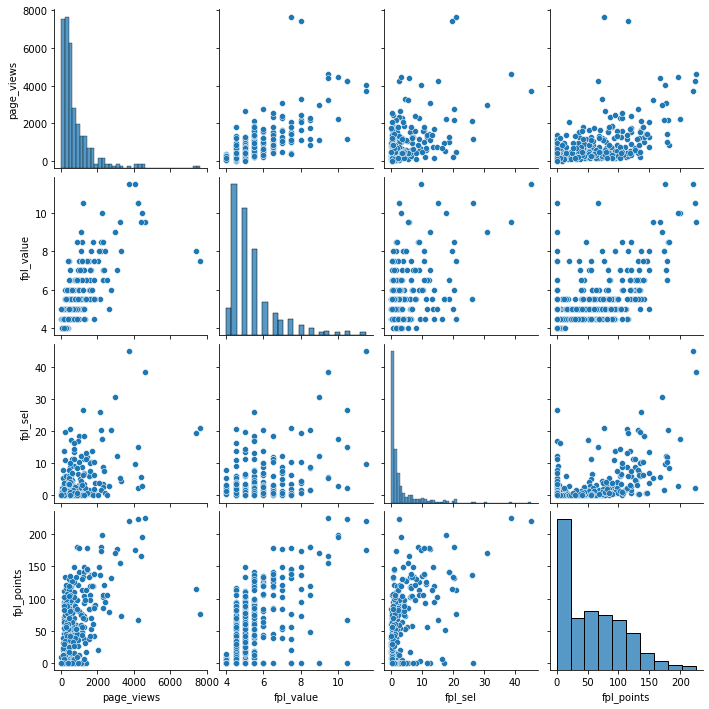

In [ ]:
cont_cols_df = final_df.drop(all_cat_cols+['market_value'], axis = 1)
sns.pairplot(cont_cols_df)

## Take care of skewness by different transform

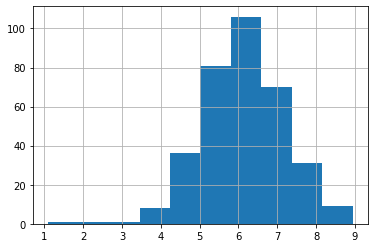

In [ ]:
cont_cols_df.page_views.apply(np.log).hist()
cont_cols_df.page_views = cont_cols_df.page_views.apply(np.log)

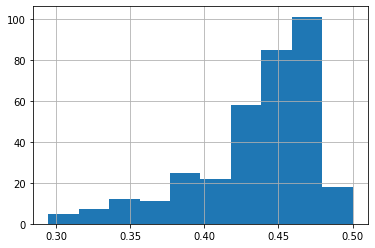

In [ ]:
cont_cols_df.fpl_value.apply(lambda x : x**(-1/2)).hist()
cont_cols_df.fpl_value = cont_cols_df.fpl_value.apply(lambda x : x**(-1/2))

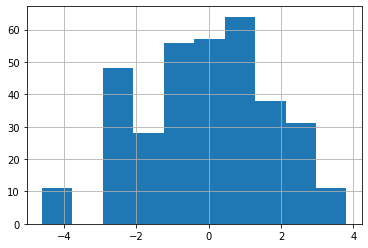

In [ ]:
cont_cols_df.fpl_sel.apply(lambda x: np.log(x+0.01)).hist()
cont_cols_df.fpl_sel = cont_cols_df.fpl_sel.apply(lambda x: np.log(x+0.01))

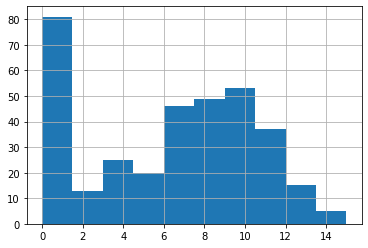

In [ ]:
cont_cols_df.fpl_points.apply(lambda x : x**(1/2)).hist()
cont_cols_df.fpl_points = cont_cols_df.fpl_points.apply(lambda x : x**(1/2))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scalar = MinMaxScaler()
cont_cols_scaled = scalar.fit_transform(cont_cols_df)

In [ ]:
final_df[cont_cols_df.columns] = cont_cols_scaled

In [ ]:
final_df.describe()

,market_value,page_views,fpl_value,fpl_sel,fpl_points,position_cat_1,position_cat_2,position_cat_3,position_cat_4,position_cat_others,region_1.0,region_2.0,region_3.0,region_4.0,region_others,nationality_Algeria,nationality_Argentina,nationality_Armenia,nationality_Australia,nationality_Austria,nationality_Belgium,nationality_Bermuda,nationality_Bosnia,nationality_Brazil,nationality_Cameroon,nationality_Chile,nationality_Colombia,nationality_Congo DR,nationality_Cote d'Ivoire,nationality_Czech Republic,nationality_Denmark,nationality_Ecuador,nationality_Egypt,nationality_England,nationality_Estonia,nationality_Finland,nationality_France,nationality_Germany,nationality_Ghana,nationality_Greece,...,nationality_Venezuela,nationality_Wales,nationality_others,new_foreign_0,new_foreign_1,new_foreign_others,club_id_1,club_id_2,club_id_3,club_id_4,club_id_5,club_id_6,club_id_7,club_id_8,club_id_9,club_id_10,club_id_11,club_id_12,club_id_13,club_id_14,club_id_15,club_id_16,club_id_17,club_id_18,club_id_19,club_id_20,club_id_others,big_club_0,big_club_1,big_club_others,new_signing_0,new_signing_1,new_signing_others,age_cat_1,age_cat_2,age_cat_3,age_cat_4,age_cat_5,age_cat_6,age_cat_others
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.0,344.000000,344.000000,344.000000,344.000000,344.0,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,...,344.000000,344.000000,344.0,344.000000,344.000000,344.0,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.0,344.000000,344.000000,344.0,344.000000,344.000000,344.0,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.0
mean,11.177471,0.641108,0.688143,0.541140,0.417168,0.331395,0.244186,0.337209,0.087209,0.0,0.351744,0.447674,0.081395,0.119186,0.0,0.005814,0.031977,0.002907,0.008721,0.005814,0.034884,0.002907,0.005814,0.026163,0.005814,0.002907,0.002907,0.008721,0.005814,0.005814,0.002907,0.005814,0.011628,0.351744,0.002907,0.002907,0.055233,0.034884,0.008721,0.002907,...,0.002907,0.029070,0.0,0.959302,0.040698,0.0,0.061047,0.052326,0.034884,0.029070,0.040698,0.040698,0.063953,0.063953,0.055233,0.063953,0.052326,0.061047,0.046512,0.046512,0.052326,0.055233,0.034884,0.052326,0.040698,0.052326,0.0,0.686047,0.313953,0.0,0.857558,0.142442,0.0,0.122093,0.177326,0.313953,0.255814,0.069767,0.061047,0.0
std,12.546844,0.137194,0.206839,0.208048,0.284946,0.471401,0.430229,0.473446,0.282553,0.0,0.478210,0.497979,0.273840,0.324479,0.0,0.076138,0.176194,0.053916,0.093113,0.076138,0.183753,0.053916,0.076138,0.159852,0.076138,0.053916,0.053916,0.093113,0.076138,0.076138,0.053916,0.076138,0.107360,0.478210,0.053916,0.053916,0.228766,0.183753,0.093113,0.053916,...,0.053916,0.168247,0.0,0.197877,0.197877,0.0,0.239764,0.223007,0.183753,0.168247,0.197877,0.197877,0.245026,0.245026,0.228766,0.245026,0.223007,0.239764,0.210897,0.210897,0.223007,0.228766,0.183753,0.223007,0.197877,0.223007,0.0,0.464774,0.464774,0.0,0.350012,0.350012,0.0,0.327870,0.382500,0.464774,0.436953,0.255126,0.239764,0.0
min,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [ ]:
# Save dataset
s = json.dumps(list(all_columns))
with open('all_columns.json', 'w') as f:
    json.dump(s, f)

cat_col_dict = json.dumps(column_dict)
with open('cat_col_dict.json', 'w') as f:
    json.dump(cat_col_dict, f)
final_df.to_csv('futbolPrepared.csv', index=False)

# Load Fresh data

In [ ]:
df = pd.read_csv('futbolPrepared.csv')
df.columns

Index(['market_value', 'page_views', 'fpl_value', 'fpl_sel', 'fpl_points',
       'position_cat_1', 'position_cat_2', 'position_cat_3', 'position_cat_4',
       'position_cat_others',
       ...
       'new_signing_0', 'new_signing_1', 'new_signing_others', 'age_cat_1',
       'age_cat_2', 'age_cat_3', 'age_cat_4', 'age_cat_5', 'age_cat_6',
       'age_cat_others'],
      dtype='object', length=107)

In [ ]:
X, y = df.drop('market_value', axis=1), df['market_value']

# Nearest Neighbors Algorithm

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_validate

In [ ]:
def kfold_verify(X, y, model):
    kfcv = KFold(shuffle=True)
    cv_scores = cross_validate(model, X, y, cv=kfcv, scoring='neg_root_mean_squared_error' )
    return -(np.mean(cv_scores['test_score']))         # Lower is better

In [ ]:
def eval_weights(weight_arr, X, y):
    """
    Parameters:-
    weight_arr: 1D array, indicating the weights for each attributes
    Returns:-
    The cross-validation error rate for given weights
    """
    model = KNeighborsRegressor(10, metric='wminkowski', metric_params={'w':weight_arr})
    return kfold_verify(X, y, model)

## Optimize weights using Genetic Algorithm

In [ ]:
class GA(object):
    # Genetic Algorithm to maximize the accuracy by finding optimal attribute weights
    def __init__(self, pop_size, num_parents, num_offspring):
        """
        Parameters:-
        pop_size : tuple, indicating the size of population and the number of genes in one chromosome
        num_parents: int, indicating the number of parents to be chosen for crossover
        num_offspring: int, indicating the number of offsprings to be produced for next generation
        """
        self.pop_size = pop_size
        self.np = num_parents
        self.no = num_offspring

    def initialize(self, X, y):
        self.X = X
        self.y = y
        self.pop = np.random.uniform(5, size=self.pop_size)

    def calc_fitness(self, eval_func):
        """
        Parameters:-
        eval_func: callable, outputs the score of a chromosome. This score needs to be maximised/minimised
        """
        fitness = np.zeros(self.pop.shape[0])
        for i in range(self.pop.shape[0]):
            fitness[i] = eval_func(self.pop[i,:], self.X, self.y)
        return fitness
    def get_parents(self, fitness):
        """
        Parameters:-
        fitness: array, indicating the fitness score for each chromosome
        """
        sorted_fitness = np.argsort(fitness)
        self.parents = np.empty((self.np, self.pop_size[1]))
        for i in range(self.np):
            self.parents[i] = self.pop[sorted_fitness[i],:]

        return self.parents
    
    def crossover(self):
        cross_point = self.pop_size[1] // 2
        # create pair of parents to produce offspring
        candidates = itertools.product(range(self.parents.shape[0]), repeat=2)
        self.offspring = np.empty((self.no, self.pop_size[1]))
        count = 1
        for i in candidates:
            if i[0] != i[1]:
                p1 = self.parents[i[0],:]
                p2 = self.parents[i[1],:]
                self.offspring[count-1, :cross_point] = p1[:cross_point]
                self.offspring[count-1, cross_point:] = p2[cross_point:]
                count += 1
            
            if count == self.no:
                break
        
        return self.offspring
    
    def get_optimal_genes(self, eval_func):
        fitness = self.calc_fitness(eval_func)
        sorted_fit = np.argsort(fitness)
        return self.pop[sorted_fit[0], :]
    
    def next_gen(self):
        self.pop = np.empty((self.np+self.no, self.pop_size[1]))
        self.pop[:self.np, :] = self.parents
        self.pop[self.np:, :] = self.offspring
        self.pop_size = self.pop.shape

In [ ]:
pop_size = (100, X.shape[1])
genetic_obj = GA(pop_size, 10, 50)

In [ ]:
genetic_obj.initialize(X, y)

In [ ]:
epochs = 10
for i in range(epochs):
    fit_score = genetic_obj.calc_fitness(eval_weights)
    next_gen_parents = genetic_obj.get_parents(fit_score)
    next_gen = genetic_obj.crossover()
    genetic_obj.next_gen()

In [ ]:
final_attr_weights = genetic_obj.get_optimal_genes(eval_weights)

## Verify the optimization

In [ ]:
knn_no_weights = KNeighborsRegressor(10)
knn_weights = KNeighborsRegressor(10, metric='wminkowski', metric_params={'w':final_attr_weights})

print('RMSE for No attribute Weights:', kfold_verify(X, y, knn_no_weights))
print('RMSE for genetically optimized attribute weights:', kfold_verify(X, y, knn_weights))

RMSE for No attribute Weights: 7.753991436449124
RMSE for genetically optimized attribute weights: 7.521140946014521


## _Tuning Number of neighbours_

In [ ]:
from yellowbrick.model_selection import ValidationCurve

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8668437fd0>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='n_neighbors',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

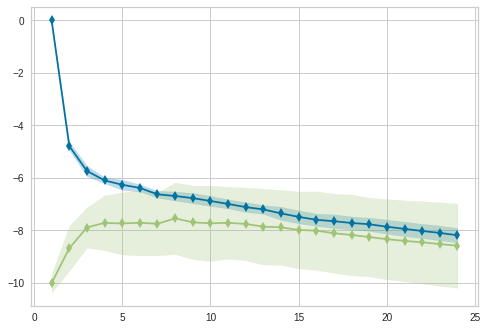

In [ ]:
n_neighbours = np.arange(1, 25, 1)
viz = ValidationCurve(knn_weights, param_name='n_neighbors', param_range=n_neighbours, cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)
# viz.show()

At around 15 nearest neighbours, The model performs well on training as well as validation set

In [ ]:
# Final model
knn_weights = KNeighborsRegressor(15, metric='wminkowski', metric_params={'w':final_attr_weights})
knn_weights.fit(X,y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='wminkowski',
                    metric_params={'w': array([1.37657651, 4.73171101, 2.0467197 , 4.11151372, 3.7207406 ,
       1.56745202, 3.22272737, 2.68064941, 4.39553871, 1.33293917,
       3.16734342, 3.19161852, 1.79092717, 3.3932422 , 4.00652914,
       2.03729382, 4.48465151, 4.71750168, 4.62471326, 1.80715577,
       3.18055259, 4.11730131, 3.09741743, 4.48...
       3.91236331, 1.29710753, 4.23291151, 2.62890028, 2.77604108,
       3.25470758, 3.95452953, 1.88115894, 1.94180899, 4.79076125,
       3.70401199, 4.15346746, 1.79687136, 4.57229148, 2.43928269,
       3.05655795, 4.32272645, 1.29323966, 4.06345083, 1.84101948,
       4.52882834, 3.3734549 , 3.42508955, 3.31587326, 1.55720904,
       3.01232739, 4.1882127 , 1.95683906, 4.61198921, 4.01173941,
       4.18455231])},
                    n_jobs=None, n_neighbors=15, p=2, weights='uniform')

In [ ]:
with open('knn_best.pkl', 'wb') as f:
    pickle.dump(knn_weights, f)

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linearModel = LinearRegression()
kfold_verify(X, y, linearModel)

661255924218.1349

In [ ]:
linearModel = LinearRegression()
linearModel.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
with open('linear_best.pkl', 'wb') as f:
    pickle.dump(linearModel, f)

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr_model = GradientBoostingRegressor()
kfold_verify(X, y, gbr_model)

6.463168338761397

## _Tuning Learning Rate_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f867545ae10>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='learning_rate',
                param_range=array([0.0001, 0.0005, 0.001 , 0.005 , 0.01  , 0.05  , 0.1   ]),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

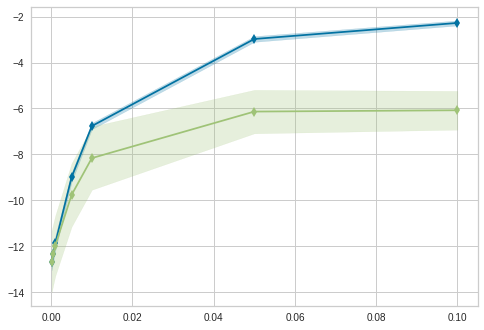

In [ ]:
viz = ValidationCurve(gbr_model, param_name='learning_rate', param_range=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

Lower learning rate, closer the validation score to training score but high error value

0.01 seems to be acceptable


## _Tuning n_estimators_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f86750a26d8>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='n_estimators',
                param_range=array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,...
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 

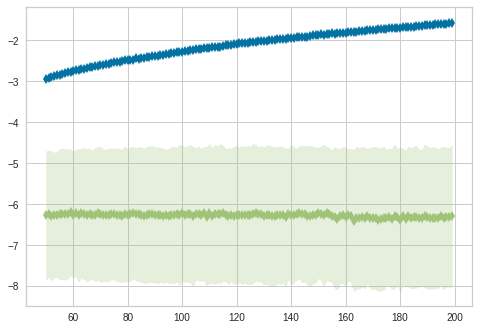

In [ ]:
viz = ValidationCurve(gbr_model, param_name='n_estimators', param_range=np.arange(50,200), cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

Doesn't matter

In [ ]:
gbr_model = GradientBoostingRegressor(learning_rate=0.01)
gbr_model.fit(X,y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
with open('gbr_best.pkl', 'wb') as f:
    pickle.dump(gbr_model, f)

# Support Vector Regression

In [ ]:
from sklearn.svm import SVR

In [ ]:
svm_model = SVR()
kfold_verify(X, y, svm_model)

10.77631018859322

## _Tuning Kernel_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f866d36ff60>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='kernel',
                param_range=array(['linear', 'poly', 'rbf', 'sigmoid'], dtype='<U7'),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

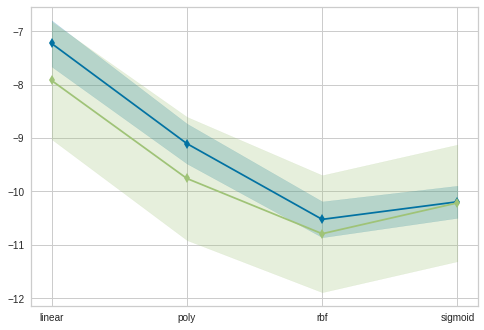

In [ ]:
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
viz = ValidationCurve(svm_model, param_name='kernel', param_range=kernel_list, cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

Linear kernel seems best

## _Tuning degree for poly kernel_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f866d2e0cf8>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='degree', param_range=array([2, 3, 4]),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

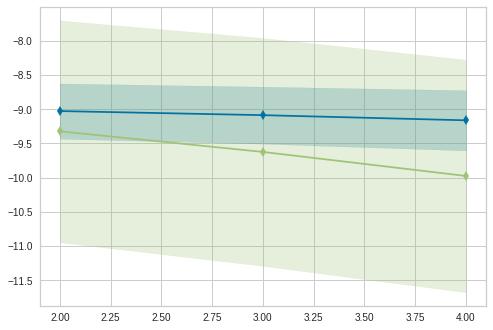

In [ ]:
viz = ValidationCurve(SVR(kernel='poly'), param_name='degree', param_range=np.arange(2,5), cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

Still worse than linear kernel

## _Tuning regularisation parameter_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f866d1d75f8>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1, param_name='C',
                param_range=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

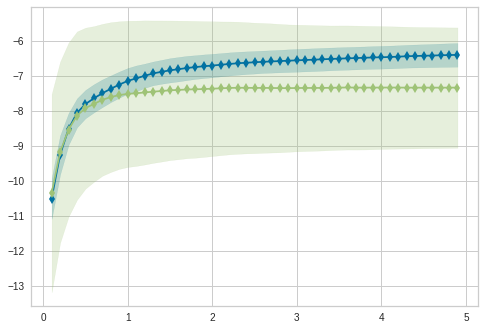

In [ ]:
viz = ValidationCurve(SVR(kernel='linear'), param_name='C', param_range=np.arange(0.1, 5, 0.1), cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

Validation score gets saturated around 1. So the default value works fine

In [ ]:
svm_model = SVR(kernel='linear', C = 1.0)
svm_model.fit(X,y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
with open('svr_best.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# Decision Tree Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor()
kfold_verify(X, y, tree)

9.154311725832113

## _Tuning criteria to measure the quality of split_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f866cfdbbe0>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='criterion',
                param_range=array(['mse', 'friedman_mse', 'mae'], dtype='<U12'),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

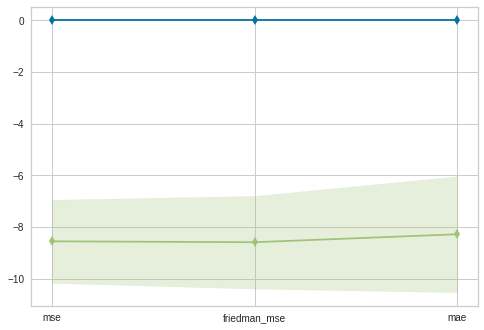

In [ ]:
criterion = ['mse', 'friedman_mse', 'mae']
viz = ValidationCurve(tree, param_name='criterion', param_range=criterion, cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

mae slightly better

## _Tuning splitting strategy_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f866d366ef0>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='splitter',
                param_range=array(['best', 'random'], dtype='<U6'),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

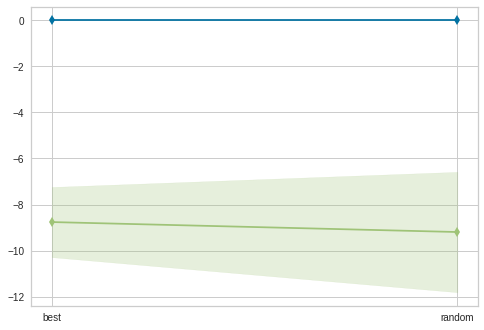

In [ ]:
splitter = ['best', 'random']
viz = ValidationCurve(tree, param_name='splitter', param_range=splitter, cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

In [ ]:
tree = DecisionTreeRegressor('mae')
tree.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
with open('tree_best.pkl', 'wb') as f:
    pickle.dump(tree, f)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()
kfold_verify(X,y,rf)

6.65993848279611

## _Tuning n_estimators_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f866cf02978>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='n_estimators',
                param_range=array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,...
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 

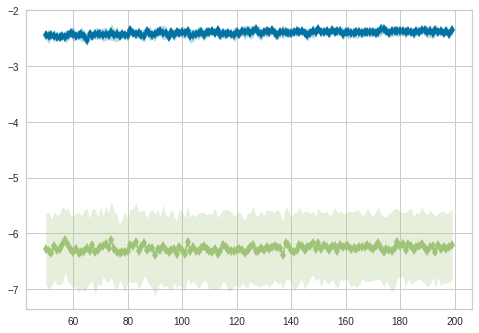

In [ ]:
viz = ValidationCurve(rf, param_name='n_estimators', param_range=np.arange(50, 200), cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

Not important

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f866d1af978>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='criterion',
                param_range=array(['mse', 'mae'], dtype='<U3'),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

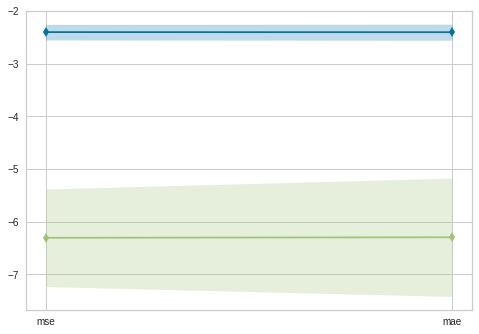

In [ ]:
criterion = ['mse', 'mae']
viz = ValidationCurve(rf, param_name='criterion', param_range=criterion, cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

Nothing

In [ ]:
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
with open('random_forest_best.pkl', 'wb') as f:
    pickle.dump(rf, f)

# Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
lasso_model = Lasso()
kfold_verify(X, y, lasso_model)

8.988298983366658

## _Tuning regularization constant_


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f866cd690b8>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='alpha',
                param_range=array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9]),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

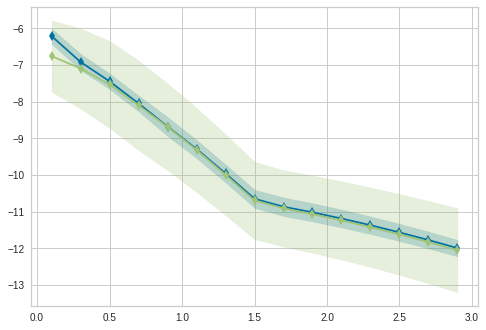

In [ ]:
viz = ValidationCurve(lasso_model, param_name='alpha', param_range=np.arange(0.1, 3, 0.2), cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

0.03 seems best

In [ ]:
lasso_model = Lasso(0.03)
lasso_model.fit(X,y)

Lasso(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
with open('lasso_best.pkl', 'wb') as f:
    pickle.dump(lasso_model, f)

# Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
ridge_model = Ridge()
kfold_verify(X, y, ridge_model)

6.986086899424902

## _Tuning regularization constant_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ValidationCurve(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f866cbddba8>,
                cv=KFold(n_splits=5, random_state=None, shuffle=True),
                groups=None, logx=False, model=None, n_jobs=1,
                param_name='alpha',
                param_range=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9]),
                pre_dispatch='all', scoring='neg_root_mean_squared_error')

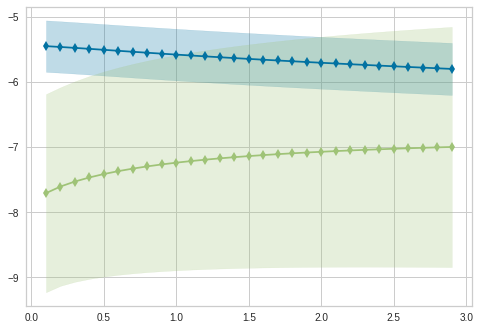

In [ ]:
viz = ValidationCurve(ridge_model, param_name='alpha', param_range=np.arange(0.1, 3, 0.1), cv = KFold(shuffle=True), scoring='neg_root_mean_squared_error')
viz.fit(X,y)

2.5 seems acceptable

In [ ]:
ridge_model = Ridge(2.5)
ridge_model.fit(X, y)

Ridge(alpha=2.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
with open('ridge_best.pkl', 'wb') as f:
    pickle.dump(ridge_model, f)

# Test data processing pipeline

In [ ]:
test_df = pd.read_csv('test_df.csv')

In [ ]:
# Read all_columns.json, cat_col_dict.json

with open('all_columns.json', 'r') as f:
    all_columns = json.load(f)

with open('cat_col_dict.json', 'r') as f:
    cat_col_dict = json.load(f)

In [ ]:
all_columns = eval(all_columns)
cat_col_dict = eval(cat_col_dict)

In [ ]:
test_df = test_df[all_columns]

In [ ]:
test_df.fpl_sel = test_df.fpl_sel.apply(lambda x : float(x[:-1]))

In [ ]:
test_df = test_df.dropna()
test_df.reset_index(drop=True, inplace=True)

In [ ]:
for i in cat_col_dict.keys():
    temp = pd.get_dummies(test_df[i], prefix=i)

    drop1 = set(cat_col_dict[i])
    drop2 = set(temp.columns)
    drop_cols = list(drop1.intersection(drop2))

    orig = pd.DataFrame(np.zeros((temp.shape[0], len(cat_col_dict[i]))), columns=cat_col_dict[i])
    orig[drop_cols] = temp[drop_cols]

    others = temp.drop(drop_cols, axis=1)
    if others.shape[1] == 0:
        others = pd.Series(np.zeros(temp.shape[0]))
    else:
        others = others.apply(np.sum, axis=1)
    others.name = i+'_others'
    test_df = pd.concat([test_df.drop(i, axis=1), orig, others], axis=1)

In [ ]:
cont_cols = list(set(all_columns) - set(cat_col_dict.keys()))
test_cont_cols = test_df[cont_cols].drop('market_value',axis=1)

In [ ]:
test_cont_cols.page_views = test_cont_cols.page_views.apply(np.log)
test_cont_cols.fpl_sel = test_cont_cols.fpl_sel.apply(lambda x : np.log(x+0.01))
test_cont_cols.fpl_points = test_cont_cols.fpl_points.apply(lambda x : x **(1/2))
test_cont_cols.fpl_value = test_cont_cols.fpl_value.apply(lambda x : x ** (-1/2))

In [ ]:
test_cont_cols_scaled = scalar.transform(test_cont_cols)
test_df[test_cont_cols.columns] = test_cont_cols_scaled

In [ ]:
test_X, test_y = test_df.drop('market_value', axis=1), test_df['market_value']

In [ ]:
import os
models = {}
for filename in os.listdir():
    if filename.endswith('.pkl'):
        with open(filename, 'rb') as f:
            models[filename[:-4]] = pickle.load(f)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
for model, obj in models.items():
    y_pred = obj.predict(test_X)
    score = mean_squared_error(test_y.values, y_pred, squared=False)
    print(f'RMSE Score for {model} = {score}')

RMSE Score for knn_best = 9.14366490278412
RMSE Score for lasso_best = 76.33370920673582
RMSE Score for tree_best = 23.339233654646993
RMSE Score for svr_best = 51.64309927350298
RMSE Score for linear_best = 864836869318.4705
RMSE Score for gbr_best = 19.950900798889606
RMSE Score for random_forest_best = 24.507186470335807
RMSE Score for ridge_best = 74.98009886168533
